# ADA 2018 - Homework 3



## Undestanding the StackOverflow community


Deadline: Nov 7th 2018, 23:59:59

Submission link: Check channel homework-3-public

StackOverflow is the most popular programming-related Q&A website. It serves as a platform for users to ask and answer questions and to vote questions and answers up or down. Users of StackOverflow can earn reputation points and "badges"; for example, a person is awarded 10 reputation points for receiving an "up" vote on an answer given to a question, and 5 points for the "up" vote on a question asked. Also, users receive badges for their valued contributions, which represents a kind of gamification of the traditional Q&A site. 

[Learn more about StackOverflow on Wikipedia](https://en.wikipedia.org/wiki/Stack_Overflow)

----

Dataset link:

https://drive.google.com/open?id=1POlGjqzw9v_pZ_bUnXGihOgk45kbvNjB

http://iccluster053.iccluster.epfl.ch/Posts.json.zip (mirror 1)

https://iloveadatas.com/datasets/Posts.json.zip (mirror 2)

Dataset description:

* **Id**: Id of the post
* **CreationDate**: Creation date of the post (String format)
* **PostTypeId**: Type of post (Question = 1, Answer = 2)
* **ParentId**: The id of the question. Only present if PostTypeId = 2
* **Score**: Points assigned by the users
* **Tags**: Tags of the question. Only present if PostTypeId = 1
* **Title**: Only present if PostTypeId = 1
* **ViewCount**: Only present if PostTypeId = 1

The dataset format is JSON. Here are examples of a question and an answer:

Question:
```json
{
    "Id": 10130734,
    "CreationDate": "2012-04-12T19:51:25.793+02:00",
    "PostTypeId": 1,
    "Score": 4,
    "Tags": "<python><pandas>",
    "Title": "Best way to insert a new value",
    "ViewCount": 3803
}
```

Answer:
```json
{  
   "CreationDate":"2010-10-26T03:19:05.063+02:00",
   "Id":4020440,
   "ParentId":4020214,
   "PostTypeId":2,
   "Score":1
}
```

----
Useful resources:

**Spark SQL, DataFrames and Datasets Guide**

https://spark.apache.org/docs/latest/sql-programming-guide.html

**Database schema documentation for the public data dump**

https://meta.stackexchange.com/questions/2677/database-schema-documentation-for-the-public-data-dump-and-sede

----

**Note:** Use Spark where possible. Some computations can take more than 10 minutes on a common notebook. Consider to save partial results on disk.

In [6]:
import findspark
findspark.init()
import pyspark

In [7]:
# Add your imports here
import pandas as pd
import numpy as np
import scipy as sp
from pyspark.sql import *
%matplotlib inline

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [8]:
import matplotlib.pyplot as plt

In [9]:
from datetime import datetime
from pyspark.sql.types import DateType
from pyspark.sql.types import TimestampType
import pytz

In [10]:
from pyspark.sql.functions import *
from pyspark.sql.functions import minute
from pyspark.sql import functions as F

---

<br>

### Task A: Convert the dataset to a more convenient format
As a warm-up task (and to avoid to warm up your laptop too much), load the dataset into a Spark dataframe, show the content, and save it in the _Parquet_ format. Use this step to convert the fields to a more convenient form.

Answer the following questions:

1. How many questions have been asked on StackOverflow?
2. How many answers have been given?
3. What is the percentage of questions with a score of 0?

**Hint:** The next tasks involve a time difference. Consider storing time in numeric format.

In [53]:
DATA_DIR = 'data/'

In [205]:
df = spark.read.parquet("posts.parquets")

In [55]:
df.printSchema()

root
 |-- CreationDate: string (nullable = true)
 |-- Id: long (nullable = true)
 |-- ParentId: long (nullable = true)
 |-- PostTypeId: long (nullable = true)
 |-- Score: long (nullable = true)
 |-- Tags: string (nullable = true)
 |-- Title: string (nullable = true)
 |-- ViewCount: long (nullable = true)



In [14]:
#df.write.mode('overwrite').parquet("posts.parquet")

Now that we saved the dataframe in the parquet format, we are loaded it and take a look at the first rows

In [56]:
df.show(3)

+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|      Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|2017-08-17T16:20:...|45740344|45740224|         2|    0|                null|                null|     null|
|2017-08-17T16:20:...|45740346|45739185|         2|    1|                null|                null|     null|
|2017-08-17T16:20:...|45740348|    null|         1|    2|<flash><react-nat...|Is it possible to...|      143|
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
only showing top 3 rows



**1) How many questions have been asked on StackOverflow?**

<br>

To find it, we are going to apply a filter on PostTypeId for value 1 and count the results:



In [16]:
stack_question = df.filter(df["PostTypeId"] == '1');
print("Question asked : " , stack_question.count());

Question asked :  15647060


<br>

**2) How many answers have been given ?**


In [17]:
stack_answers = df.filter(df["PostTypeId"] == '2');
print("Answers : " ,stack_answers.count());

Answers :  25192772


Another way to proceed is to groupBy the PostTypeId and then count for each.

In [18]:
df.groupBy("PostTypeId").count().show()

+----------+--------+
|PostTypeId|   count|
+----------+--------+
|         1|15647060|
|         2|25192772|
+----------+--------+



<br>

**3) What is the percentage of questions with a score of 0?**

<br>

 - First, we will count questions with `0` score
 - Then, we simply divide it by number of questions found

In [19]:
stack_zero_question = stack_question.filter(stack_question["Score"] == '0');
print('Number of questions with a score of 0: ',stack_zero_question.count())

Number of questions with a score of 0:  7282714


In [20]:
print("Percentage of question with a score of 0 : %.2f" % ((stack_zero_question.count()/stack_question.count())*100) + "%")

Percentage of question with a score of 0 : 46.54%


---

<br>

### Task B: What are the 10 most popular tags?

What are the most popular tags in StackOverflow? Use Spark to extract the information you need, and answer the following questions with Pandas and Matplotlib (or Seaborn):

1. What is the proportion of tags that appear in fewer than 100 questions?
2. Plot the distribution of the tag counts using an appropriate representation.
3. Plot a bar chart with the number of questions for the 10 most popular tags.

For each task describe your findings briefly.

__1)__

We would like to get the proportion of tags.
First of all we have to extract in the dataset the questions. For this we could use the parameter PostTypeId=1 or ParentId= None. Then, the questions are often linked with multiple tags so we have to split these different tags and group them by tag name. We then have to be carefull that the tag names are different to none in order to extract them.

Finally we will reduce by tag name the dataset and count each occurence of tags.

By the way, we could say that the PostTypeId is a redundent column, as we can get this information using the ParentId column. 

In [21]:
# r[5] : Tags != none and r[2] : ParentId = None meaning this is a questions
# Each question has different tags => Split it
# Correct the tag name which is included between <tagname> and assign value 1 to count frequency
# Reduce by key each tag and count number of occurences for each tags

tags = df.rdd.filter(lambda r: r[2] == None and r[5] != None)\
            .flatMap(lambda r: [(r[1], g) for g in r[5].split('><')])\
            .map(lambda r: [r[1].replace('>','').replace('<',''),1])\
            .reduceByKey(lambda a,b: a+b) 

total_tags = tags.count() # Total length of rdd => total number of tags 

#Number of tags with less than 100 appearances.
fewer100_tags = tags.filter(lambda r: r[1] <= 100).count() # Number of tags appearing in less than 100 questions


52994
36118


In [63]:
print("Total number of tags : " + str(total_tags))
print("Number of tags with less than 100 questions : " + str(fewer100_tags))
print("\nProportion of tags mentionned in less than 100 questions : " + str(100*fewer100_tags/total_tags) + " %")

Total number of tags : 52994
Number of tags with less than 100 questions : 36118

Proportion of tags mentonned in less than 100 questions : 68.15488545873117 %


We can say that this is already an important part of the dataset. It looks like the tag distribution is following a Zipf's law. We will check this in the next question.

__2)__

We now want to plot the distribution of the tag counts. We already extracted the tag counts previously. We willl then export it to a Pandas dataframe in order to get some visualization.

In [64]:
tags_DF = spark.createDataFrame(tags, ['tags','freq'])
tags_Pandas = tags_DF.toPandas()

In [65]:
tags_Pandas.describe()

,freq
count,5.299400e+04
mean,8.809450e+02
std,1.598885e+04
min,1.000000e+00
25%,1.000000e+01
50%,3.700000e+01
75%,1.570000e+02
max,1.585495e+06


We can already have some information about the tags distribution. Indeed, up to the 75% quartile the values are in the same order (e+2) but the mean is greater and the max is really higher. Then this is confirming the Zipf's law distribution guess. 

Let's plot the histogram !

Text(0.5,1,"Question's Tags counts distribution : Histogram")

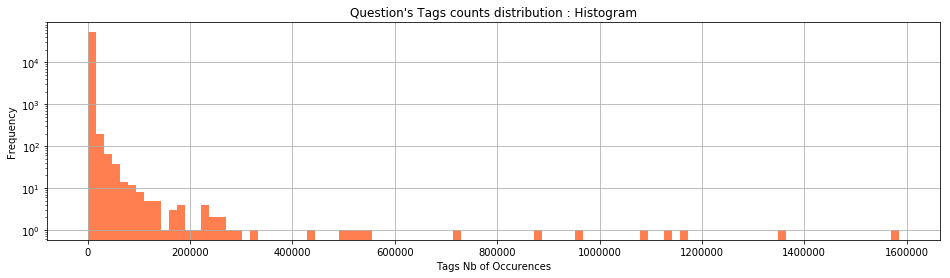

In [111]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
fig.set_size_inches(16,4)

tags_Pandas.hist(log=True, bins = 100, color="coral", figsize =(16,4), ax=axes)

axes.set_xlabel("Tags Nb of Occurences")
axes.set_ylabel("Frequency")
axes.set_title("Question's Tags counts distribution : Histogram")

We have now form of the histogram. It is indeed a power law. It could then be interesting to plot some curves 
- 1) Basic graph distribution
- 2) Cumulative representation of the tags

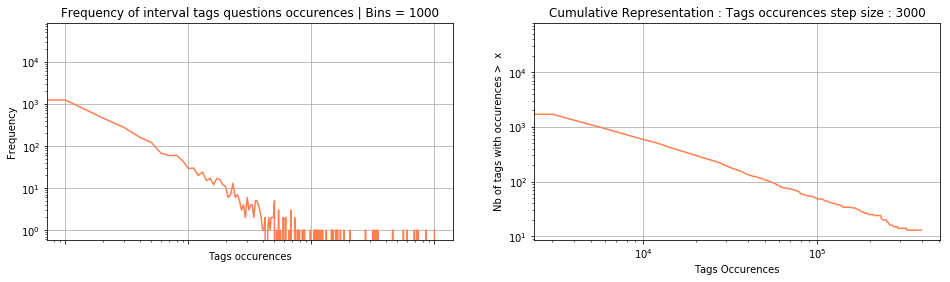

In [92]:
# Prepare the figure to create 2 subplots
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(16,4)


# Tag distribution graph

cut_tags = pd.cut(tags_Pandas['freq'], bins=1000)
ax2 = cut_tags.value_counts(sort=False).plot(loglog=True,ax=axes[0], color='coral')
ax2.grid(True)
ax2.set_title("Frequency of interval tags questions occurences | Bins = 1000")
ax2.set_xlabel("Tags occurences")
ax2.set_ylabel("Frequency")


# Cumulative Representation

x2 = np.arange(tags_Pandas['freq'].max()/4, step = 3000 )
# Initialize the y vector
y2 = []
# Stores in y the number of communes grater than the threshold defined by x
for threshold in x2:
    y2.append(tags_Pandas[tags_Pandas['freq'] >= threshold].shape[0])


# Transform the y list into a Series using the Population index    
y2 = pd.Series(y2,index=pd.Index(x2, name='Tags'))
# Plot using a loglog scale
ax2 = y2.plot(loglog=True, ax=axes[1], color='coral')
ax2.grid(True)
ax2.set_xlabel("Tags Occurences")
ax2.set_ylabel("Nb of tags with occurences >  x")
ax2.set_title("Cumulative Representation : Tags occurences step size : 3000")


plt.show()


__3)__

We now want to extract and plot the number of questions for the 10 most popular tags. 
We will then use the previous dataframe and sort. Then we will extract the 10 first values of this table and plot it using bars.

In [85]:
# Sort the dataframe containing the number of questions per tags
sorted_tags = tags_Pandas.sort_values('freq', ascending=False)

# Extract the 10 first values
first_tags = sorted_tags.iloc[0:10,:]
first_tags = first_tags.set_index('tags')

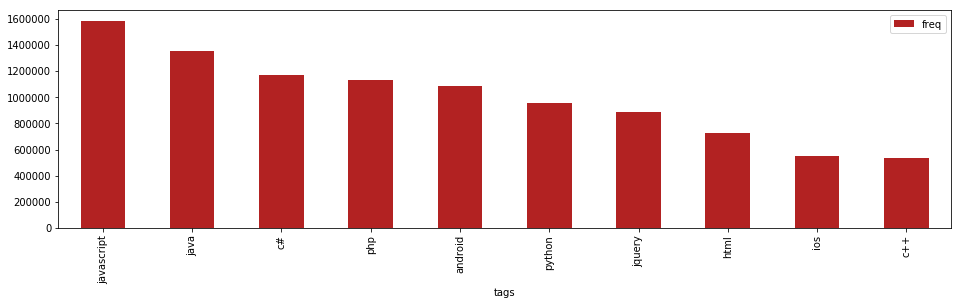

In [93]:
first_tags.plot.bar(figsize =(16,4),color="firebrick")


The resulting bar graph seems to be correct as the printed tags seems to be the most famous programming languages.

### Task C: View-score relation

We want to investigate the correlation between the view count and the score of questions.

1. Get the view count and score of the questions with tag ```random-effects``` and visualize the relation between these two variables using an appropriate plot.
2. Are these two variables correlated? Use the Pearson coefficient to validate your hypothesis. Discuss your findings in detail.


We would like to study the view count and score attributes of the tag "random-effects". 
- We will then first extract these data. 
- We filter only the questions (ParentId, r[2] = None), and we get only the tags, r[5] not equal to None.
- We then split the tags names, and extract only the concerned tag 'random-effects'. 

In [95]:
# First filter : Only get Questions (ParentId = None) and valid Tag name (!= None)
# FlatMap : Get only columns tag,score,viewcount and split each Tags into distinct tag
# Map : Correct the values of Tag names by removing '>' and '<' char (due to the previous split)
# Filter by selecting only tags equal to 'random-effects'

# r[4] : score / r[7] : viewcount

tags_randeffets = df.rdd.filter(lambda r: r[2] == None and r[5] != None) \
            .flatMap(lambda r: [(g, r[4], r[7]) for g in r[5].split('><')]) \
            .map(lambda r: [r[0].replace('>','').replace('<',''), r[1], r[2]]) \
            .filter(lambda r: r[0] == 'random-effects')

rand_effects = tags_randeffets.count()  


In [96]:
print("Number of questions with tags : <random-effets> : " + str(rand_effects))

Number of questions with tags : <random-effets> : 100


In [97]:
# Create a DataFrame to only get the interesting attributes.
randeffects_DF = spark.createDataFrame(tags_randeffets, ['tag','score','viewcount'])
randeffects_Pandas = randeffects_DF.toPandas()
randeffects_Pandas.head()

,tag,score,viewcount
0,random-effects,0,12
1,random-effects,0,495
2,random-effects,0,220
3,random-effects,0,21
4,random-effects,5,126


We now have the data corresponding to the 'random-effects' tag with the score and the associated viewcount.

We now want to see the relation between score and viewcount, it is then interesting to use a scatter plot to have the score value for each associated viewcount. 

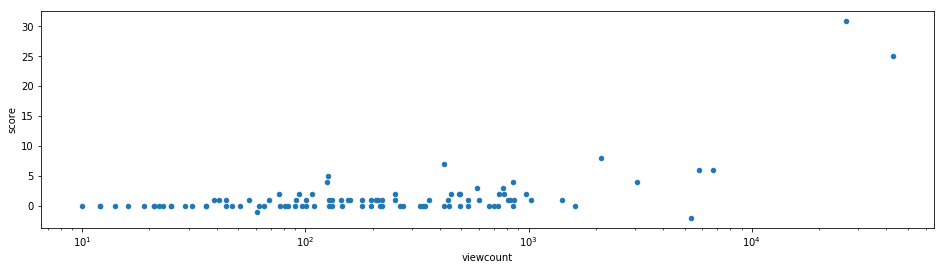

In [55]:
randeffects_Pandas.plot.scatter('viewcount','score', figsize =(16,4), logx=True)


__2)__ 

We now want to see if the 2 variables are correlated. 
The view count and the score seems to be correlated. Indeed in the scatterplot we see that when the viewcount is increasing, the score value is following and seems to have greater values. 

We will then use the Pearson coefficient to confirm this hypothesis.

Pearson coeffciient = cov(X,Y) / ( std(X) * std(Y) )

In [98]:
# Only get the score and viewcount values
randeffects_Pandas2 = randeffects_Pandas[['score','viewcount']]

In [99]:
cov = randeffects_Pandas2.cov()
cov = cov['score']['viewcount']
print("Covariance between score and viewcount : " +str(cov))

Covariance between score and viewcount : 18463.136363636368


In [100]:
std_score = np.std(randeffects_Pandas2['score'])
print("Std for score : " + str(std_score))

std_viewcount = np.std(randeffects_Pandas2['viewcount'])
print("Std for viewcount : " + str(std_viewcount))

Std for score : 4.1340053217188775
Std for viewcount : 5011.9178605699435


In [101]:
print('Pearson coefficent for score and viewcount = ' + str(cov/(std_score*std_viewcount)))

Pearson coefficent for score and viewcount = 0.8911083252466169


Pearson coefficient has a value between +1 and −1, where 1 is total positive linear correlation, 0 is no linear correlation, and −1 is total negative linear correlation.

We can see that our Pearson coefficient (=0.89) tends to show a positive linear correlation.
This is then confirming the hypothesis, the attributes Viewcount and Score are correlated.

Indeed when we think about the problem, if there is more people viewing the question, then there is potentially more people able to give a score. If nobody saw the question then nobody will give a score increment. That is why there is a relationship between the viewcount and the score.

### Task D: What are the tags with the fastest first answer?

What are the tags that have the fastest response time from the community? We define the response time as the difference in seconds between the timestamps of the question and of the first answer received.

1. Get the response time for the first answer of the questions with the tags ```python``` and ```java```.
2. Plot the two distributions in an appropriate format. What do you observe? Describe your findings and discuss the following distribution properties: mean, median, standard deviation.
3. We believe that the response time is lower for questions related to Python (compare to Java). Contradict or confirm this assumption by estimating the proper statistic with bootstrapping. Visualize the 95% confidence intervals with box plots and describe your findings.
3. Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.


For question 1, we have to :
- Select only *questions* (filter by post type) with _java_ and _python_ tags (filter tags)
- Select their respectives answers
- Compare creations dates and keep the fastest for every question

We will perform the two first step using spark dataframe and then move to panda dataframe to treat and work with datetime object to compare dates.

In [21]:
data = spark.read.parquet("posts.parquets")

In [22]:
data.show(5)

+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|        CreationDate|      Id|ParentId|PostTypeId|Score|                Tags|               Title|ViewCount|
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
|2017-08-17T16:20:...|45740344|45740224|         2|    0|                null|                null|     null|
|2017-08-17T16:20:...|45740346|45739185|         2|    1|                null|                null|     null|
|2017-08-17T16:20:...|45740348|    null|         1|    2|<flash><react-nat...|Is it possible to...|      143|
|2017-08-17T16:20:...|45740350|45739102|         2|    1|                null|                null|     null|
|2017-08-17T16:20:...|45740352|42473616|         2|    0|                null|                null|     null|
+--------------------+--------+--------+----------+-----+--------------------+--------------------+---------+
only showi

Now that we load the data, we are going to filter all question which contain at least one tag, then filter those tag by python. 
Futhermore, when we look deeper in the tags list, we can see that they are tags such as : python3-2, ipython, etc.. In our case, we made the assumption that the tag 'python' is like the parent of all tags related to python. It meens that if a question has 'python-unittest' tag, it will also have python.

In [23]:
# Filter from the data, python questions with their Id and date
python_ID = data.rdd.filter(lambda x : x[3] == 1 and x[5] != None) \
                        .flatMap(lambda x : [(x[0], x[1], x[3], g) for g in x[5].split('><')]) \
                        .filter(lambda x : "<python>" in x[3]) \
                      

python_ID.take(5)

[('2017-08-17T16:52:11.117+02:00', 45740943, 1, '<python>'),
 ('2017-08-17T17:03:01.267+02:00', 45741146, 1, '<python>'),
 ('2017-08-17T17:19:53.047+02:00', 45741399, 1, '<python>'),
 ('2017-08-17T18:20:39.737+02:00', 45742440, 1, '<python>'),
 ('2017-08-17T19:01:01.713+02:00', 45743080, 1, '<python>')]

In [24]:
# Create a dataframe from the pipelineRDD. We keep the same schema
# We index each question columns with Q to refer to question, because we are going to join these table with the data one
schema = ['QDate','QId','QTypeId', 'QTags'];
df_python = spark.createDataFrame(python_ID, schema)

Now we are goint to select all answers related to the python question. We can easily find them by their parentId

In [25]:
# Dataframe join on parentId of answers with python questions IDs
python_anwsers = data.join(df_python, data.ParentId == df_python.QId)

# Remove some useless column
python_anwsers = python_anwsers.drop('Score','Title','Tags','ViewCount')

python_anwsers.show(5)

+--------------------+------+--------+----------+--------------------+------+-------+--------+
|        CreationDate|    Id|ParentId|PostTypeId|               QDate|   QId|QTypeId|   QTags|
+--------------------+------+--------+----------+--------------------+------+-------+--------+
|2009-02-05T14:17:...|516070|  516039|         2|2009-02-05T14:11:...|516039|      1|<python>|
|2009-02-05T14:22:...|516093|  516039|         2|2009-02-05T14:11:...|516039|      1|<python>|
|2009-02-05T14:22:...|516094|  516039|         2|2009-02-05T14:11:...|516039|      1|<python>|
|2009-02-05T14:28:...|516116|  516039|         2|2009-02-05T14:11:...|516039|      1|<python>|
|2009-02-05T14:29:...|516121|  516039|         2|2009-02-05T14:11:...|516039|      1|<python>|
+--------------------+------+--------+----------+--------------------+------+-------+--------+
only showing top 5 rows



The fourth fisrt columns are related to the answsers while the second fourth columns are related to question linked to the answers. As they can be several answers for one question, this is why we can see several times the same question.

We detailled above all the process to get all fasters answers to python questions. Below we are going to do the same for all java questions and answers.

In [26]:
# Filter from the data, java questions with their Id and date
java_ID = data.rdd.filter(lambda x : x[3] == 1 and x[5] != None) \
                        .flatMap(lambda x : [(x[0], x[1], x[3], g) for g in x[5].split('><')]) \
                        .filter(lambda x : "<java>" in x[3]);

# Create a dataframe from the pipelineRDD. We keep the same schema
df_java = spark.createDataFrame(java_ID, schema);

# Dataframe join on parentId of answers with python questions IDs
java_anwsers = data.join(df_java, data.ParentId == df_java.QId)

# Remove some useless column
java_anwsers = java_anwsers.drop('Score','Title','Tags','ViewCount')

java_anwsers.show(5)

+--------------------+------+--------+----------+--------------------+------+-------+------+
|        CreationDate|    Id|ParentId|PostTypeId|               QDate|   QId|QTypeId| QTags|
+--------------------+------+--------+----------+--------------------+------+-------+------+
|2009-01-14T10:23:...|442531|  442494|         2|2009-01-14T10:11:...|442494|      1|<java>|
|2009-05-24T03:41:...|903026|  903005|         2|2009-05-24T03:27:...|903005|      1|<java>|
|2009-05-24T09:48:...|903444|  903005|         2|2009-05-24T03:27:...|903005|      1|<java>|
|2009-06-07T17:54:...|962406|  962400|         2|2009-06-07T17:48:...|962400|      1|<java>|
|2009-06-07T17:56:...|962413|  962400|         2|2009-06-07T17:48:...|962400|      1|<java>|
+--------------------+------+--------+----------+--------------------+------+-------+------+
only showing top 5 rows



To be able to compare the posted question and answers dates, we are going to compare them. They are currently in the dataframes as strings, we will clean a bit those strings and convert them into datetime and compare.

For the next steps, we will work with panda dataframes instead of pyspark to be able to use python datetime apis
For cleaning phase, we remove the 'T' for time. Also the time zone in python, it has to be without ':' (ie : +0100 instead of +01:00).

In [27]:
# Convert to panda dataframes
java_df = java_anwsers.toPandas()
python_df = python_anwsers.toPandas()

In [28]:
# We do small correction on the string dates to be able to transform them into datetime
python_df['CreationDate'].replace(regex=True,inplace=True,to_replace=r'T',value=r' ')
python_df['QDate'].replace(regex=True,inplace=True,to_replace=r'T',value=r' ')

java_df['CreationDate'].replace(regex=True,inplace=True,to_replace=r'T',value=r' ')
java_df['QDate'].replace(regex=True,inplace=True,to_replace=r'T',value=r' ')

python_df.head(5)

,CreationDate,Id,ParentId,PostTypeId,QDate,QId,QTypeId,QTags
0,2009-02-05 14:17:39.440+01:00,516070,516039,2,2009-02-05 14:11:32.043+01:00,516039,1,<python>
1,2009-02-05 14:22:01.880+01:00,516093,516039,2,2009-02-05 14:11:32.043+01:00,516039,1,<python>
2,2009-02-05 14:22:05.640+01:00,516094,516039,2,2009-02-05 14:11:32.043+01:00,516039,1,<python>
3,2009-02-05 14:28:08.310+01:00,516116,516039,2,2009-02-05 14:11:32.043+01:00,516039,1,<python>
4,2009-02-05 14:29:56.077+01:00,516121,516039,2,2009-02-05 14:11:32.043+01:00,516039,1,<python>


In [29]:
# Return the date string without the ':' in the time zone. It is the 26 position in the string
def remove_char(strDate):
    pos = 26;
    first_part = strDate[:pos] 
    second_part = strDate[pos+1:]
    return first_part + second_part

In [30]:
# Apply remove_char in every dates
java_df['CreationDate'] = java_df['CreationDate'].apply(lambda x : remove_char(x))
java_df['QDate'] = java_df['QDate'].apply(lambda x : remove_char(x))

python_df['CreationDate'] = python_df['CreationDate'].apply(lambda x : remove_char(x))
python_df['QDate'] = python_df['QDate'].apply(lambda x : remove_char(x))

In [31]:
python_df.head()

,CreationDate,Id,ParentId,PostTypeId,QDate,QId,QTypeId,QTags
0,2009-02-05 14:17:39.440+0100,516070,516039,2,2009-02-05 14:11:32.043+0100,516039,1,<python>
1,2009-02-05 14:22:01.880+0100,516093,516039,2,2009-02-05 14:11:32.043+0100,516039,1,<python>
2,2009-02-05 14:22:05.640+0100,516094,516039,2,2009-02-05 14:11:32.043+0100,516039,1,<python>
3,2009-02-05 14:28:08.310+0100,516116,516039,2,2009-02-05 14:11:32.043+0100,516039,1,<python>
4,2009-02-05 14:29:56.077+0100,516121,516039,2,2009-02-05 14:11:32.043+0100,516039,1,<python>


In [32]:
# Change the string into datetime object
timeFormat = "%Y-%m-%d %H:%M:%S.%f%z"
utc_tz = pytz.timezone('UTC');
def toTime(x) :
    return datetime.strptime(x,timeFormat).astimezone(utc_tz)

In [33]:
java_df['CreationDate'] = java_df['CreationDate'].apply(lambda x : toTime(x))
java_df['QDate'] = java_df['QDate'].apply(lambda x : toTime(x))

python_df['CreationDate'] = python_df['CreationDate'].apply(lambda x : toTime(x))
python_df['QDate'] = python_df['QDate'].apply(lambda x : toTime(x))

Now that dates are in datetime format, we can substract to the answer time the question time and then we will keep the lower one for each question.

In [34]:
# Substract question to answser times
python_df['PyDiff'] = python_df['CreationDate'] - python_df['QDate']
java_df['JavaDiff'] = java_df['CreationDate'] - java_df['QDate']

python_df.head(5)

,CreationDate,Id,ParentId,PostTypeId,QDate,QId,QTypeId,QTags,PyDiff
0,2009-02-05 13:17:39.440000+00:00,516070,516039,2,2009-02-05 13:11:32.043000+00:00,516039,1,<python>,00:06:07.397000
1,2009-02-05 13:22:01.880000+00:00,516093,516039,2,2009-02-05 13:11:32.043000+00:00,516039,1,<python>,00:10:29.837000
2,2009-02-05 13:22:05.640000+00:00,516094,516039,2,2009-02-05 13:11:32.043000+00:00,516039,1,<python>,00:10:33.597000
3,2009-02-05 13:28:08.310000+00:00,516116,516039,2,2009-02-05 13:11:32.043000+00:00,516039,1,<python>,00:16:36.267000
4,2009-02-05 13:29:56.077000+00:00,516121,516039,2,2009-02-05 13:11:32.043000+00:00,516039,1,<python>,00:18:24.034000


In [35]:
# Convert the time into total amount of seconds
python_df['PyDiff'] = python_df['PyDiff'].apply(lambda x : x.total_seconds())
java_df['JavaDiff'] = java_df['JavaDiff'].apply(lambda x : x.total_seconds())

In [36]:
# Select the minimum time by question id
python_df = python_df.groupby('QId')['PyDiff'].agg('min')
java_df = java_df.groupby('QId')['JavaDiff'].agg('min')

# Groupby and agg returned series, we put them in dataframes
python_df = pd.DataFrame(python_df)
java_df = pd.DataFrame(java_df)

In [37]:
python_df.head()

,PyDiff
QId,
1829,931.437
3061,1268.193
10123,592.227
26595,653.937
33534,633.673


In [38]:
java_df.head()

,JavaDiff
QId,
41894,169.557
69702,1433.467
91214,511.930
93177,147.107
95419,35.226


Question 2 : Plot the two distributions in an appropriate format

Well, to start, we choose to plot them using boxplot. It is a strong tool that helps us to visualize how the data is distributed accross the value range and the mean.
Another way is to plot them using basic plot where we put the x axis to the ascending order of id. It means by order of published questions and so the answers.

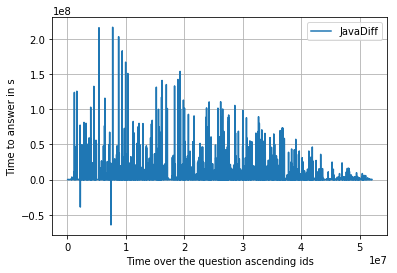

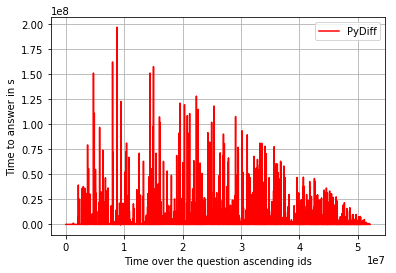

In [39]:
Tplot = java_df.plot(y='JavaDiff')
Tplot.grid(True)
Tplot.set_ylabel("Time to answer in s")
Tplot.set_xlabel("Time over the question ascending ids")

Tplot = python_df.plot(y='PyDiff', color='red')
Tplot.grid(True)
Tplot.set_ylabel("Time to answer in s")
Tplot.set_xlabel("Time over the question ascending ids")

plt.show()

Now if we look more at the graphs behaviors, they seem to follow the same trend. At the beginning the answsers were very long to come and the more the time goes, the more the time decrease. But to be honest, those are not efficient at all !!
They just give an overview of global time answers. There are to be two mistakes in the java graph with two negatives values, might be Luky Lucke who answered... ;) 

Joke appart, we can just suppose some error in the dates because we take into account the possible difference of timezone. Also some values in both graph can reach up to 2.10^8 seconds, which corresponds to around 55 000hours. Either it is a mistake or a really big oulier. There are also some small negatives values in python which barely visible.


One be boostrap the data in the 95%, we might be able to analyse more. We are going to remove the outliers and negatives values, convert seconds into minuts in order to have statistics with not to big numbers.

In [40]:
# Remove negatives values
python_df = python_df[python_df['PyDiff']>0]
java_df = java_df[java_df['JavaDiff']>0]

# Converting into minuts
python_df['Minuts'] = python_df['PyDiff']/60
java_df['Minuts'] = java_df['JavaDiff']/60

In [41]:
# Boostrap with 95% confidence intervals
python_95p = np.percentile(python_df.PyDiff, 95)
delay_python = python_df[python_df['PyDiff']<python_95p]

java_95p = np.percentile(java_df.JavaDiff, 95)
delay_java = java_df[java_df['JavaDiff']<java_95p]

In [42]:
delay_python.describe()

,PyDiff,Minuts
count,54034.00000,54034.000000
mean,874.08759,14.568126
std,1351.83095,22.530516
min,0.64000,0.010667
25%,206.45475,3.440913
50%,394.30350,6.571725
75%,881.59200,14.693200
max,10331.77300,172.196217


In [43]:
delay_java.describe()

,JavaDiff,Minuts
count,61667.000000,61667.000000
mean,757.984047,12.633067
std,1107.218706,18.453645
min,12.720000,0.212000
25%,191.470000,3.191167
50%,359.993000,5.999883
75%,782.558000,13.042633
max,8053.700000,134.228333


First of all, what we can see is that their are much more java question compare to python (54 034 against 61 667). Their mean are quite the same, 12.6 minutes for java and 14.5 for python (same for variance). If we look closer to the quartile, both have almost the same kind of distribution. 
Maybe looking at new kinds of plot this time can be more relevant of the data.

The goal to Bootstrap is to estimate the mean, standard deviation and the mean of the response time for each dataset. We are going to boostrap 500 times on 70% of the dataset. Of course the boostrap is done with replacement in order to be completely random (and because it is how boostrapping is normally done).

In [44]:
def boostrapping500(dataframe, fraction):
    mean=[]
    std=[]
    median=[]
    
    for i in range (500) :
        sample = dataframe.sample(frac=fraction,replace=True)
        # Add mean
        mean_sample = sample.Minuts.mean()
        mean.append(mean_sample)
        # Add std
        std_sample = sample.Minuts.std()
        std.append(std_sample)
        # Add median
        median_sample=sample.Minuts.median()
        median.append(median_sample)

    # Return LISTS
    return mean, std, median

Boostrap for python delta questions-answers times

In [45]:
#compute bootstrapping for python dataset
mean_python, std_python, median_python = boostrapping500(delay_python, 0.7)
t = np.asarray(mean_python)
#print(t)
#compute the mean of every statistics after bootstraping
mean_python_boostrap = np.mean(np.asarray(mean_python))
std_python_boostrap = np.mean(np.asarray(std_python))
median_python_boostrap = np.mean(np.asarray(median_python))

print("Mean = {0:.2f} minuts, Median = {1:.0f} minuts and standard deviation = {2:.2f} minuts".format(mean_python_boostrap, std_python_boostrap, median_python_boostrap)); 

Mean = 14.58 minuts, Median = 23 minuts and standard deviation = 6.58 minuts


Boostrap for java delta questions-answers times

In [46]:
#compute bootstrapping for python dataset
mean_java, std_java, median_java = boostrapping500(delay_java, 0.7)

#compute the mean of every statistics after bootstraping
mean_java_boostrap = np.mean(np.asarray(mean_java))
std_java_boostrap = np.mean(np.asarray(std_java))
median_java_boostrap = np.mean(np.asarray(median_java))
print("Mean = {0:.2f} minuts, Median = {1:.0f} minuts and standard deviation = {2:.2f} minuts".format(mean_java_boostrap, std_java_boostrap, median_java_boostrap));

Mean = 12.64 minuts, Median = 18 minuts and standard deviation = 6.00 minuts


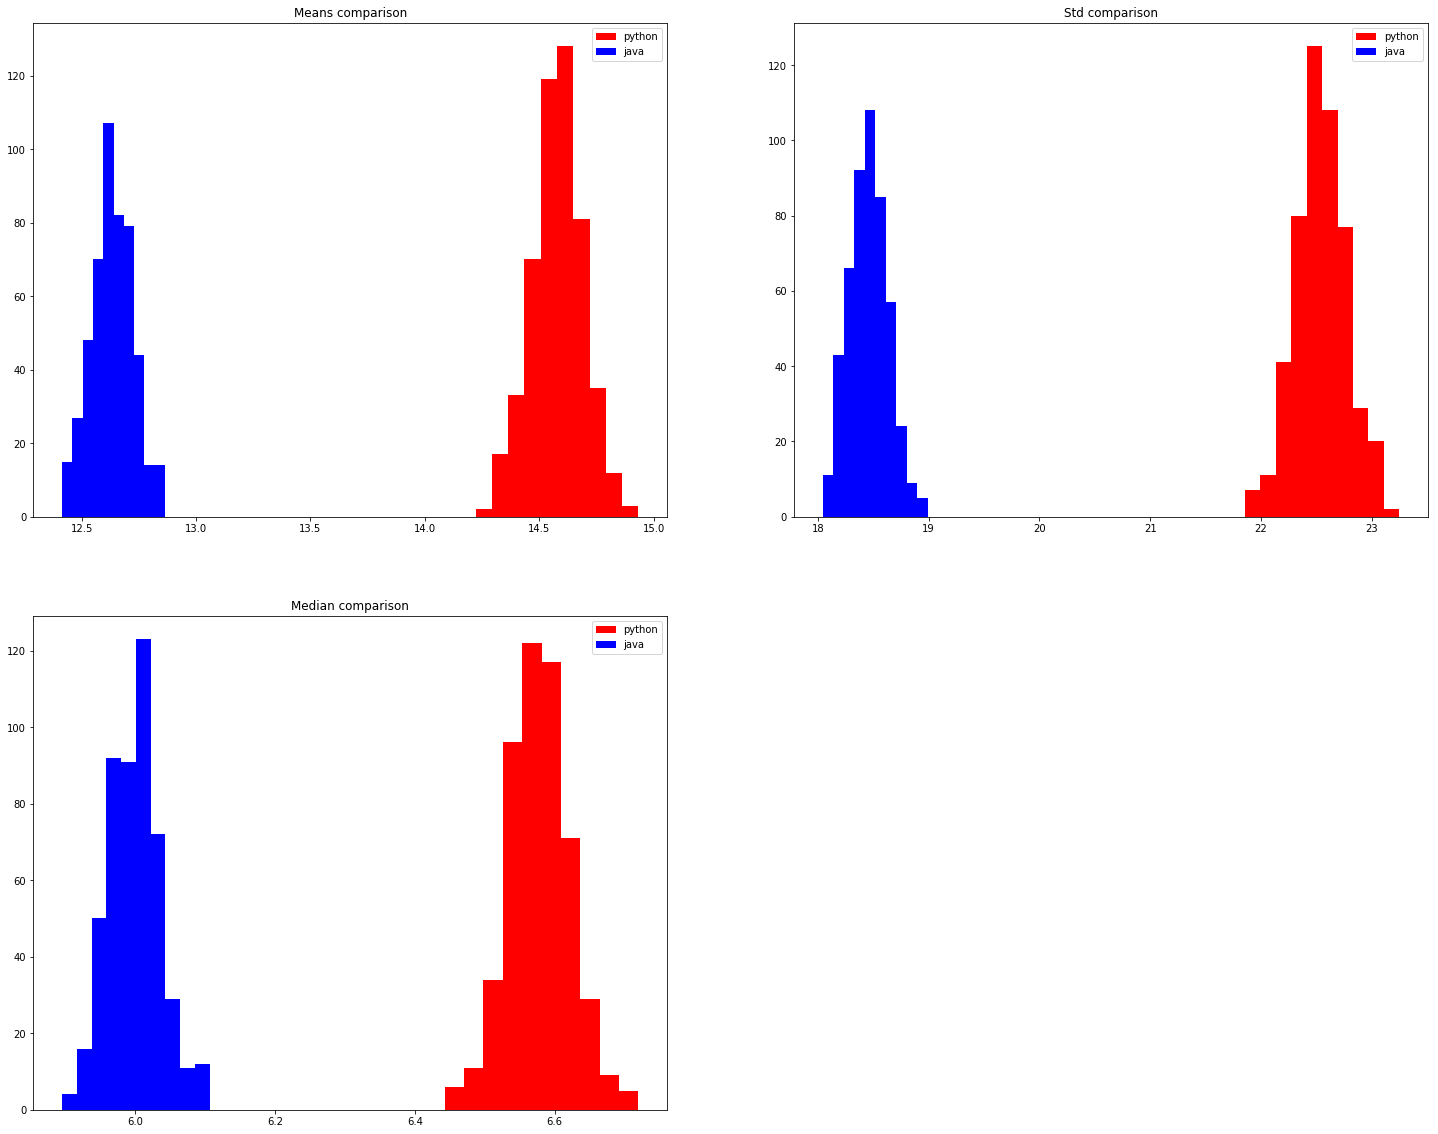

In [47]:
#ploting histograms of three statistics values to compare
plt.figure(figsize=(25,20))

plt.subplot(221)
plt.hist(mean_python,label="python",color='red')
plt.hist(mean_java,label="java",color='blue')
plt.title('Means comparison')
plt.legend()

plt.subplot(222)
plt.hist(std_python,label="python",color='red')
plt.hist(std_java,label="java",color='blue')
plt.title('Std comparison')
plt.legend()

plt.subplot(223)
plt.hist(median_python,label="python",color='red')
plt.hist(median_java,label="java",color='blue')
plt.title('Median comparison')
plt.legend()

The three distribution help to clearly state that Java has the lower response times compare to python.  
Now we are going to have a look closer to the data using boxplots and see if it is more effcient to visualize the data

{'whiskers': [<matplotlib.lines.Line2D at 0x10f396828>,
 'caps': [<matplotlib.lines.Line2D at 0x10f3b20f0>,
 'boxes': [<matplotlib.lines.Line2D at 0x10f396978>],
 'medians': [<matplotlib.lines.Line2D at 0x10f3b2940>],
 'fliers': [<matplotlib.lines.Line2D at 0x10f3b2d68>],
 'means': []}

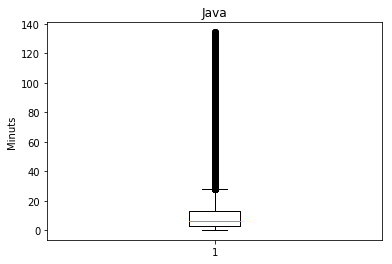

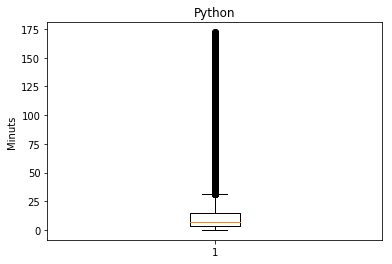

In [48]:
# Box plot for java minuts
fig1, ax1 = plt.subplots()
ax1.set_title('Java')
ax1.set_ylabel('Minuts')
ax1.boxplot(delay_java['Minuts'])

# Box plot for python minuts
fig2, ax2 = plt.subplots()
ax2.set_title('Python')
ax2.set_ylabel('Minuts')
ax2.boxplot(delay_python['Minuts'])

As we can see, it is a completly mess, we cannot see anything. The fact is that with boxplot each dot represent and outlier, so maybe a boxplot wihtout them can be better.
But what are all those outlier and why ? Maybe a first assumptions is due to all very specific questions that did not have quick answers.

{'whiskers': [<matplotlib.lines.Line2D at 0x10e1400b8>,
 'caps': [<matplotlib.lines.Line2D at 0x10e73c860>,
 'boxes': [<matplotlib.lines.Line2D at 0x10e140208>],
 'medians': [<matplotlib.lines.Line2D at 0x10e1280f0>],
 'fliers': [],
 'means': []}

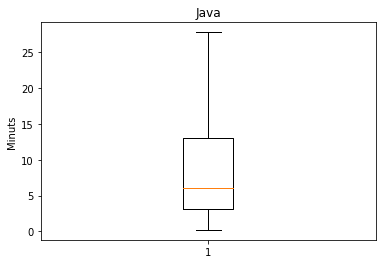

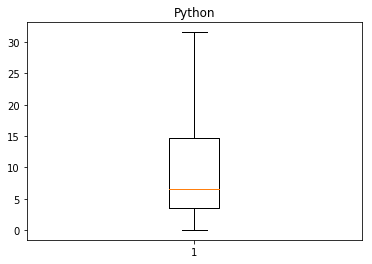

In [49]:
fig1, ax1 = plt.subplots()
ax1.set_title('Java')
ax1.set_ylabel('Minuts')
ax1.boxplot(delay_java['Minuts'], showfliers=False)

fig2, ax2 = plt.subplots()
ax2.set_title('Python')
ax1.set_ylabel('Minuts')
ax2.boxplot(delay_python['Minuts'], showfliers=False)

They both have a really close distribution which cannot really allow to contradict or comfirm your assumption. The boostrap method was more efficient.

<br>

**4)** Repeat the first analysis (D1) by using the proper statistic to measure the response time for the tags that appear at least 5000 times. Plot the distribution of the 10 tags with the fastest response time.
We though about repeating the same process as we just have done for python and java. So code is bellow but it is the worst technique. After 4 hours of running, the process was still not finished.
We did not find a proper way to solve this

Let's start by getting every first answer for each questions. This will then allow us to compare the creation date of the question, to the date of the first answer:

In [206]:
# Creation of the template to be able to use SQL
df.registerTempTable('df')

In [207]:
# DataFrame with all first answer for each questions
first_answer = """
select MIN(CreationDate) as First_answer, ParentId 
from (select CreationDate, ParentId from df
      where PostTypeId = 2 and CreationDate is not null)
group by ParentId
"""
first_answer_data = spark.sql(first_answer)
first_answer_data.registerTempTable('first_answer')

In [208]:
# Take each question with its first answer
question_query = """
select * 
from df
where PostTypeId = 1 and CreationDate is not null
"""

question_data = spark.sql(question_query)
question_data.registerTempTable('question')

In [94]:
question_data.head(1)

[Row(CreationDate='2017-08-17T16:20:28.873+02:00', Id=45740348, ParentId=None, PostTypeId=1, Score=2, Tags='<flash><react-native>', Title='Is it possible to embed Adobe flash into a react-native app?', ViewCount=143)]

Now we can get all thhe dates information:

In [209]:
Tags_response_time = """
select CreationDate, Tags, First_answer
from question
inner join answer_min on question.Id = first_answer.ParentId
"""
Tags_time_data = spark.sql(Tags_response_time)
Tags_time_data.head(1)

[Row(CreationDate='2008-08-05T13:07:40.563+02:00', Tags='<c#><dataset><datatable>', First_answer='2008-08-05T13:10:26.487+02:00')]

In [210]:
Tags_response_time = """
select DATE_FORMAT(CreationDate, 'yyyy-mm-dd HH:mm:ss.000'), Tags, DATE_FORMAT(First_answer, 'yyyy-mm-dd HH:mm:ss.000')
from question
inner join answer_min on question.Id = answer_min.ParentId
"""
Tags_time_data = spark.sql(Tags_response_time)

In [173]:
Tags_time_data.head(1)

[Row(date_format(CAST(CreationDate AS TIMESTAMP), yyyy-mm-dd HH:mm:ss.000)='2008-07-05 13:07:40.000', Tags='<c#><dataset><datatable>', date_format(CAST(First_answer AS TIMESTAMP), yyyy-mm-dd HH:mm:ss.000)='2008-10-05 13:10:26.000')]

We can now compare the dates we have collected and get the difference in seconds.

Below is a simple example of time comparison:

In [213]:
import datetime as dt
_format = 'yyyy-mm-dd HH:mm:ss.000'

a = dt.datetime.strptime('2008-07-05 13:07:40.000', '%Y-%m-%d %H:%M:%S.%f')
b = dt.datetime.strptime('2008-07-05 13:07:42.000', '%Y-%m-%d %H:%M:%S.%f')

(b-a).total_seconds()

2.0

Let's put the time difference inside a column "Time_diff"

In [ ]:
import datetime as dt
_format = '%Y-%m-%d %H:%M:%S.%f'

Tags_time_data = pd.DataFrame(Tags_time_data, columns = ["First_answer", "Tags", "CreationDate"])

Tags_time_data = Tags_time_data.withColumn("Time_diff",\
                    (dt.datetime.strptime(Tags_time_data.First_answer, _format) -\
                     dt.datetime.strptime(Tags_time_data.CreationDate, _format)).total_seconds())

Tags_time_data.registerTempTable('Tags_time_data')

In [154]:
Tags_time_data.head(1)

[Row(CreationDate='2008-08-05T13:07:40.563+02:00', Tags='<c#><dataset><datatable>', First_answer='2008-08-05T13:10:26.487+02:00', Time_diff=None)]

In [97]:
Tags_time_data_filter = """
select * from Tags_time_data
where Time_diff > 0
"""
Tags_time_data = spark.sql(Tags_time_data_filter)

Tags_time = Tags_time_data.rdd.flatMap(lambda r: [(x,r.Time_diff) for x in (r.Tags[1:-1].split('><'))]).groupByKey()\
                    .map(lambda x : (x[0], list(x[1]))).collect()

We will now wright a function to compute the median of the time reponse for only the tags that appear at least 5'000 times:

In [200]:
def Clear_Tags_time(Tags_time):
    Result = []
    for Tag, time_list in Tags_time:
        if len(time_list) >= 5000:
            median_value = np.median(time_list)
            Result.append((Tag, time_list, median_value))
    return Result

In [201]:
# Compute the median and take the 10 first with the smaller median of the time difference between the question and its first answer
Result_Tag = Clear_Tags_time(Tags_time)
Result_Tag_data = pd.DataFrame(Result_Tag, columns = ["Tags", "Time_diff_list", "Median"])
Result_Tag_data.set_index("Tags", inplace = True)
Result_Tag_data.drop(["Time_diff_list"], axis =1, inplace = True)
Result_Tag_data.sort_values("Median", ascending = True, inplace = True)
Result_Tag_data_top_10 = Result_Tag_data.head(10)

Finally, we can plot our results:

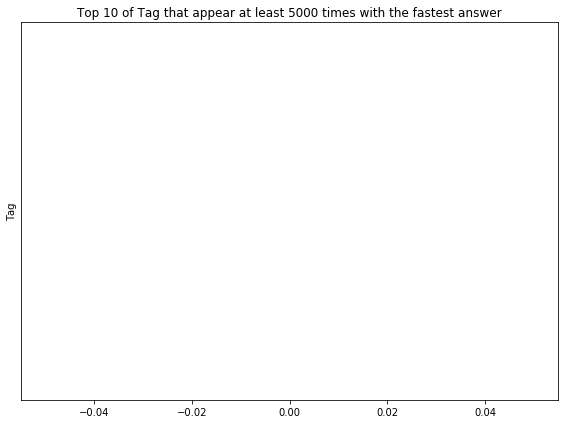

In [218]:
y = Result_Tag_data['Median'].values[:10]
x = Result_Tag_data.index.values[:10]

fig, ax = plt.subplots(figsize=(8, 6))
index = range(len(y))
bar_width = 0.7

ax.barh(index, y, bar_width)

ax.set_ylabel('Tag')
ax.set_title('Top 10 of Tag that appear at least 5000 times with the fastest answer')
ax.set_yticks(index)
ax.set_yticklabels(x)
ax.set_ylim(-1, len(x))
fig.tight_layout()
plt.show()


---

<br>

### Task E: What's up with PySpark?
The number of questions asked regarding a specific topic reflect the public’s interest on it. We are interested on the popularity of PySpark. Compute and plot the number of questions with the ```pyspark``` tag for 30-day time intervals. Do you notice any trend over time? Is there any correlation between time and number of questions?

<br>

#### **1) PySpark popularity over the years :**

Let's start by getting all the questions with tag `pyspark` and selecting their `CreationDate`:

In [180]:
pyspark_question = """
select CreationDate from df
where Tags like '%<pyspark>%' and CreationDate is not null and PostTypeId = 1
"""
pyspark_question = spark.sql(pyspark_question)
pyspark_question.registerTempTable('pyspark_question')
pyspark_question = pyspark_question.withColumnRenamed('date_format(CAST(CreationDate AS TIMESTAMP), hh:mm-dd/MM/yyy)', 'Time')

pyspark_question.show(10)

+--------------------+
|        CreationDate|
+--------------------+
|2017-08-17T16:40:...|
|2017-08-17T20:36:...|
|2016-08-03T08:10:...|
|2016-08-03T08:22:...|
|2016-08-03T12:06:...|
|2016-08-03T12:19:...|
|2016-08-03T16:34:...|
|2016-08-03T18:48:...|
|2016-08-03T18:52:...|
|2016-08-03T20:00:...|
+--------------------+
only showing top 10 rows



Now that we managed to get all the questions, and their dates, we can regroup them. 

We will regroup them according to their month to easily get 30-day time intervals, and count the number of questions that were asked during this month:

In [181]:
query_pyspark_group_by = """
SELECT DATE_FORMAT(CreationDate, "Y-MM"), COUNT(DATE_FORMAT(CreationDate, "Y-MM"))
FROM pyspark_question
GROUP BY DATE_FORMAT(CreationDate, "Y-MM")
"""
pyspark_group_by_data = spark.sql(query_pyspark_group_by)
pyspark_group_by_data.registerTempTable('pyspark_group_by')
pyspark_group_by_data = pyspark_group_by_data.withColumnRenamed('date_format(CAST(CreationDate AS TIMESTAMP), Y-MM)', 'Date')
pyspark_group_by_data = pyspark_group_by_data.withColumnRenamed('count(date_format(CAST(CreationDate AS TIMESTAMP), Y-MM))', 'Count')

pyspark_group_by_data.show(10)

+-------+-----+
|   Date|Count|
+-------+-----+
|2017-09|  367|
|2017-10|  366|
|2016-02|  178|
|2018-06|  371|
|2017-05|  263|
|2017-11|  311|
|2015-05|   50|
|2018-03|  472|
|2015-12|  129|
|2018-02|  363|
+-------+-----+
only showing top 10 rows



We can then put the selected data in a pandas dataframe:

In [182]:
df_pyspark = pyspark_group_by_data.toPandas()
df_pyspark.head()

,Date,Count
0,2017-09,367
1,2017-10,366
2,2016-02,178
3,2018-06,371
4,2017-05,263


<br>

A first look at our data shows us that we have some missing values: `2014-05`, `2014-06`, `2014-07`, `2014-09`. These dates are the ones that just followed the first pyspark release. It is therefore easy to imagine that no questions have yet been asked. We will therefore add these dates with 0 questions asked each time.

In order to make our data more logical and understandable, we will also sort them by ascending date.

In [183]:
d = {'Date': ['2014-05', '2014-06', '2014-07', '2014-09'], 'Count': [0, 0, 0, 0]} # Missing values
df = pd.DataFrame(data=d)
df_pyspark = pd.concat([df_pyspark,df]).sort_values('Date',ascending=True)
df_pyspark.head()

,Date,Count
38,2014-04,1
0,2014-05,0
1,2014-06,0
2,2014-07,0
24,2014-08,1


<br>

When we look at our data more closely, we realize that **we have some outliers at the end of our dataset, for dates `2018-09` and `2018-12`**, we will remove them.

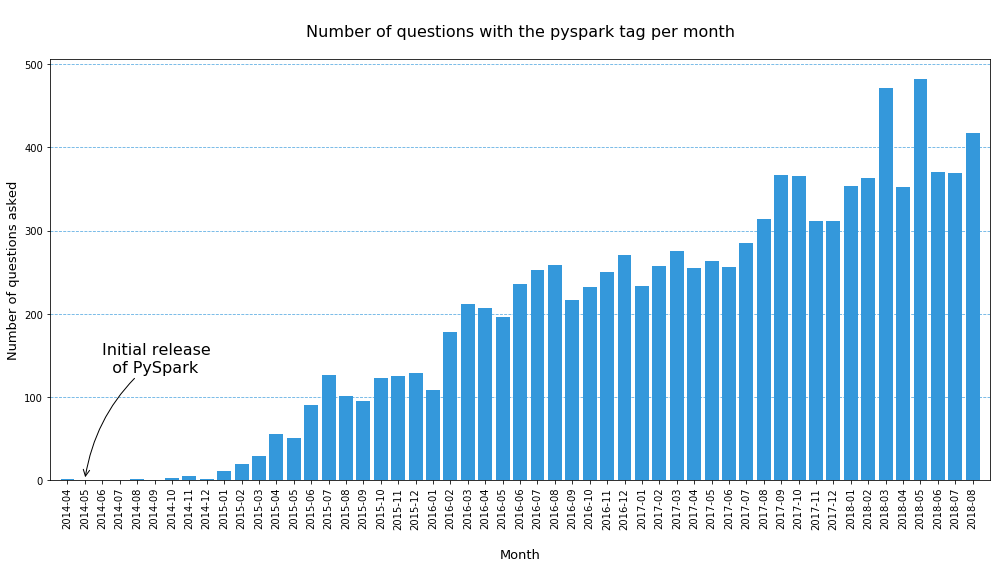

In [184]:
y, x = df_pyspark.Count.iloc[0:-2], df_pyspark.Date.iloc[0:] # Removing 2 outliers at the end

fig, ax = plt.subplots(figsize=(14, 8))
index = range(len(y))
bar_width = 0.8

ax.bar(index, y, bar_width, color='#3498db')

ax.set_xlabel('\nMonth', fontsize=13)
ax.set_ylabel('Number of questions asked', fontsize=13)
ax.set_title('\nNumber of questions with the pyspark tag per month\n', fontsize=16)
ax.set_xticks(index)
plt.xticks(rotation=90)
ax.set_xticklabels(x)
ax.set_xlim(-1, len(x)-2)
fig.tight_layout()
ax.grid(axis='y', alpha=0.8,color='#3498db', linestyle='--')

plt.annotate('Initial release\n  of PySpark',
             xy=(1, 1),
             xytext=(2, 130), fontsize=16,
             arrowprops=dict(arrowstyle="->", connectionstyle="arc3,rad=.2"))
plt.show()

<br>

#### **1) Correlation between PySpark questions and time :**

<br>

As we saw on the previous graph, the augmentation of question is strongly correlated with the time, in a linear way.

<br>

**Let's now look at different time scales to see if we can find information on the use of pysparks over time.**

In [185]:
df_pyspark = pyspark_question.toPandas()
df_pyspark['CreationDate'] = pd.to_datetime(df_pyspark['CreationDate'])

<br>

**PySpark usage during a day :**

<br>

In [186]:
df_pyspark_hour = df_pyspark
df_pyspark_hour['hour'] = df_pyspark_hour['CreationDate'].dt.hour
df_pyspark_hour = df_pyspark_hour.groupby(['hour']).size().reset_index(name='count')
df_pyspark_hour.head()

,hour,count
0,0,223
1,1,239
2,2,248
3,3,253
4,4,332


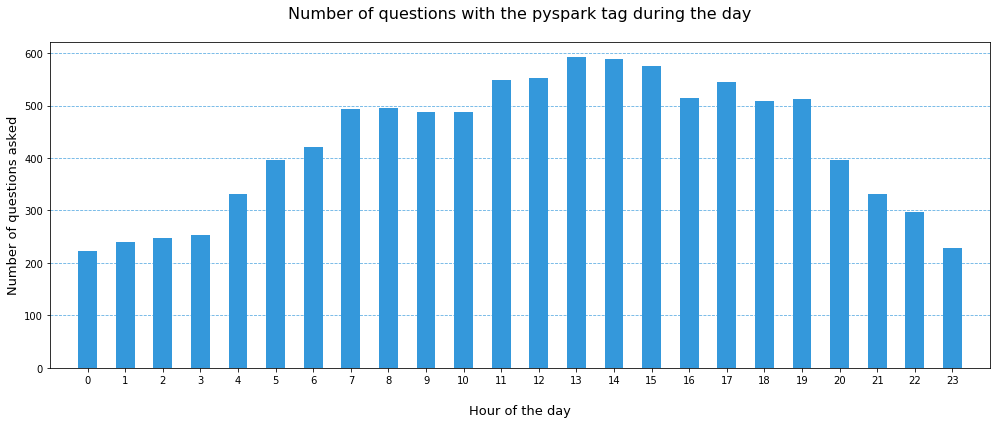

In [187]:
y, x = df_pyspark_hour['count'], df_pyspark_hour.index

fig, ax = plt.subplots(figsize=(14, 6))
index = range(len(y))
bar_width = 0.5

ax.bar(index, y, bar_width, color='#3498db')

ax.set_xlabel('\nHour of the day', fontsize=13)
ax.set_ylabel('Number of questions asked', fontsize=13)
ax.set_title('Number of questions with the pyspark tag during the day\n', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(x)
ax.set_xlim(-1, len(x))
fig.tight_layout()
ax.grid(axis='y', alpha=0.8,color='#3498db', linestyle='--')

plt.show()

Linear correlation between number of questions and hours of the day:

In [188]:
df_pyspark_hour.corr()

,hour,count
hour,1.000000,0.301336
count,0.301336,1.000000


We can clearly see that there is a correlation between hour of the day and pyspark request. However, this correlation is not linear, rather sinusoidal or quadratic-like. This indicate that people asking questions about pyspark are not evenly distributed between time zones around the world. Indeed, certain time zones have a very tiny population of programmers (Pacific) in comparison with others.

<br>

**PySpark usage during a week :**

<br>

In [189]:
df_pyspark_day = df_pyspark
df_pyspark_day['day'] = df_pyspark_day['CreationDate'].dt.dayofweek
df_pyspark_day = df_pyspark_day.groupby(['day']).size().reset_index(name='count')
df_pyspark_day

,day,count
0,0,1655
1,1,1891
2,2,1865
3,3,1882
4,4,1605
5,5,659
6,6,709


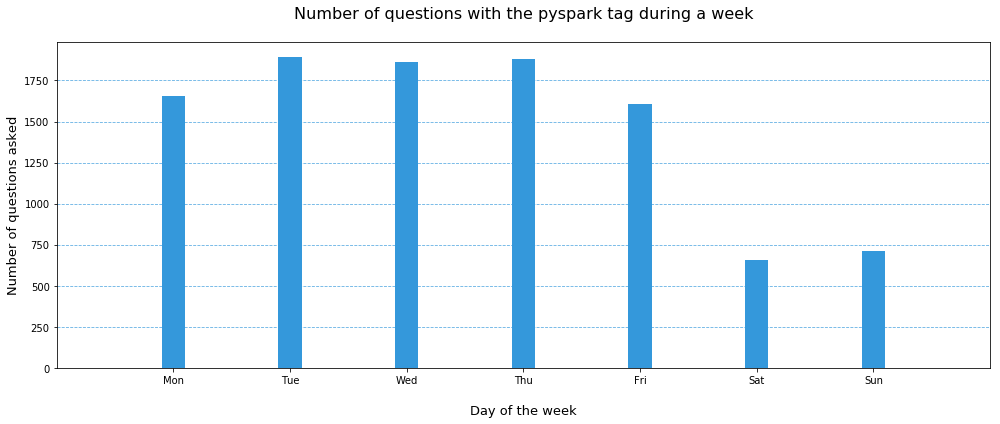

In [190]:
y, x = df_pyspark_day['count'], df_pyspark_day.index

fig, ax = plt.subplots(figsize=(14, 6))
index = range(len(y))
bar_width = 0.2

ax.bar(index, y, bar_width, color='#3498db')

ax.set_xlabel('\nDay of the week', fontsize=13)
ax.set_ylabel('Number of questions asked', fontsize=13)
ax.set_title('Number of questions with the pyspark tag during a week\n', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax.set_xlim(-1, len(x))
fig.tight_layout()
ax.grid(axis='y', alpha=0.8,color='#3498db', linestyle='--')

plt.show()

Linear correlation between number of questions and day of the week:

In [191]:
df_pyspark_day.corr()

,day,count
day,1.000000,-0.785157
count,-0.785157,1.000000


We can notice very clearly that the number of questions about pyspark asked during weekend is lower in regard with weekdays. There is some kind of step-function-like correlation is this case.

<br>

**PySpark usage during a year :**

<br>

In [192]:
df_pyspark_month = df_pyspark
df_pyspark_month['month'] = df_pyspark_month['CreationDate'].dt.month
df_pyspark_month = df_pyspark_month.groupby(['month']).size().reset_index(name='count')
df_pyspark_month

,month,count
0,1,707
1,2,818
2,3,987
3,4,872
4,5,989
5,6,954
6,7,1031
7,8,1094
8,9,686
9,10,723


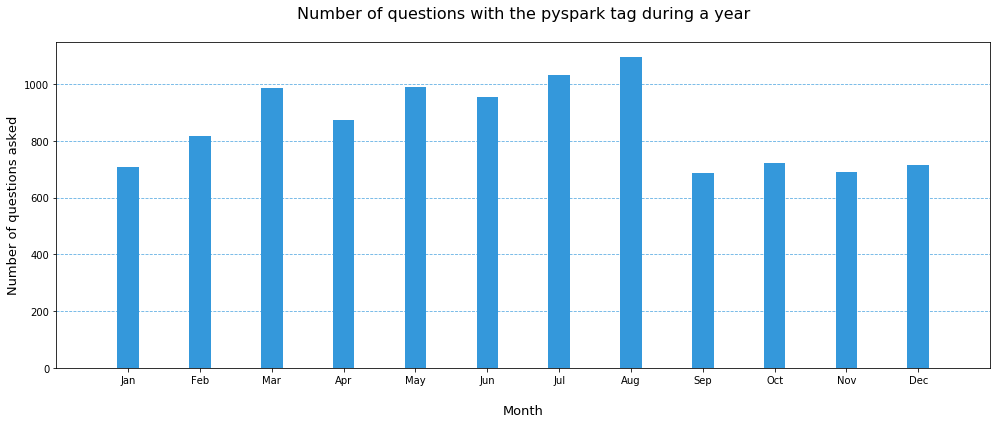

In [193]:
y, x = df_pyspark_month['count'], df_pyspark_month['month']
fig, ax = plt.subplots(figsize=(14, 6))
index = range(len(y))
bar_width = 0.3

ax.bar(index, y, bar_width, color='#3498db')

ax.set_xlabel('\nMonth', fontsize=13)
ax.set_ylabel('Number of questions asked', fontsize=13)
ax.set_title('Number of questions with the pyspark tag during a year\n', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'])
ax.set_xlim(-1, len(x))
fig.tight_layout()
ax.grid(axis='y', alpha=0.8,color='#3498db', linestyle='--')

plt.show()

Linear correlation between number of questions and month of the year:

In [194]:
df_pyspark_month.corr()

,month,count
month,1.000000,-0.288707
count,-0.288707,1.000000


In this last analysis, we can see that trends are emerging in the months of the year, but no very precise correlation can be seen in our graph.